In [1]:
# importing necessary packages
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import torch.utils.data as data_utils
from PIL import Image, ImageFile
import json
from torch.optim import lr_scheduler
import time
import os
import argparse
import copy
import pandas as pd
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2
# Import useful sklearn functions
import sklearn
from sklearn.metrics import cohen_kappa_score, accuracy_score

import time
from tqdm import tqdm_notebook
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# loading dataset
train_csv = pd.read_excel('/content/drive/MyDrive/DR_Noman_1000/trainLabels.xlsx')
#test_csv = pd.read_excel('/content/drive/MyDrive/DR_Noman/testLabels.xlsx')

In [4]:
print('Train Size = {}'.format(len(train_csv)))
#print('Test Size = {}'.format(len(test_csv)))

Train Size = 1000


In [5]:
train_csv.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [6]:
#test_csv.head()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


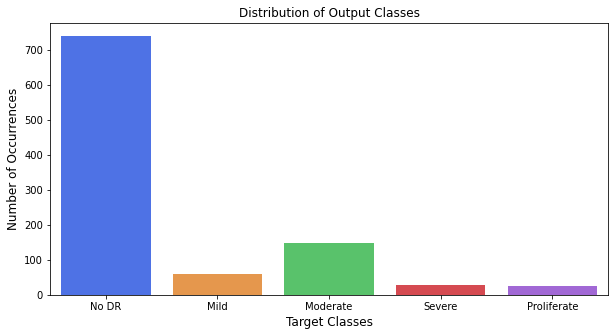

In [7]:
# EDA
counts = train_csv['level'].value_counts()
class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate']
for i,x in enumerate(class_list):
    counts[x] = counts.pop(i)

plt.figure(figsize=(10,5))
sns.barplot(counts.index, counts.values, alpha=0.8, palette='bright')
plt.title('Distribution of Output Classes')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Target Classes', fontsize=12)
plt.show()

In [8]:
#unzipping training data
#from zipfile import ZipFile
#zf = ZipFile('/content/drive/MyDrive/DR_Noman_3000/train.zip', 'r')
#zf.extractall('/content/drive/MyDrive/DR_Noman_3000')
#zf.close()

In [9]:
# image count in training folder
dir_path = r'/content/drive/MyDrive/DR_Noman_1000/train'
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
print('File count:', count)

File count: 1000


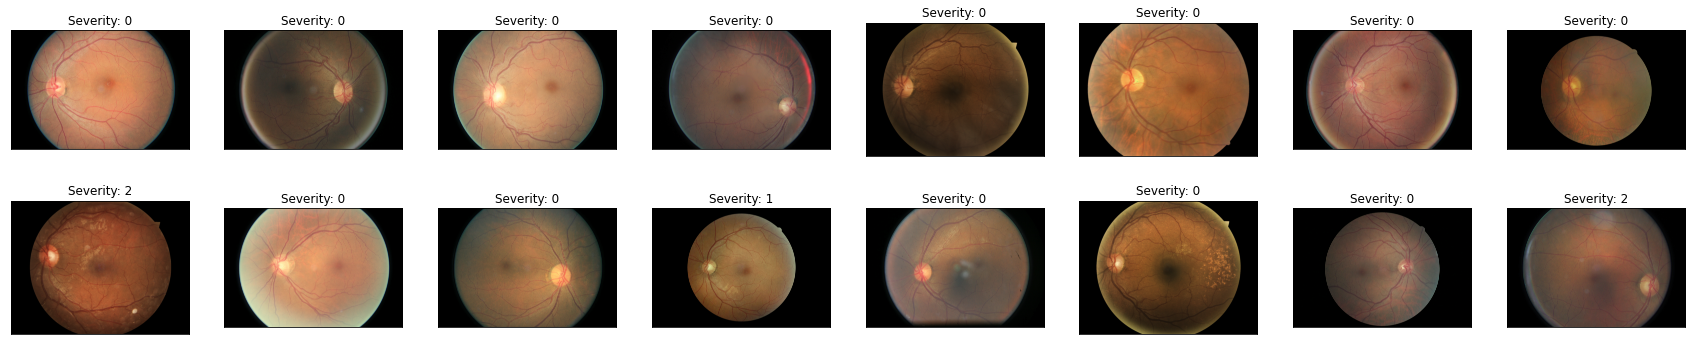

In [10]:
# display 16 images from training set
fig = plt.figure(figsize=(30, 6))
train_imgs = os.listdir(dir_path)
for idx, img in enumerate(np.random.choice(train_imgs, 16)):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    im = Image.open(dir_path + "/" + img)
    plt.imshow(im)
    lab = train_csv.loc[train_csv['image'] == img.split('.')[0], 'level'].values[0]
    ax.set_title('Severity: %s'%lab)

In [11]:
#unzipping testing data
#from zipfile import ZipFile
#zf = ZipFile('/content/drive/MyDrive/DR_Noman_Updated/test.zip', 'r')
#zf.extractall('/content/drive/MyDrive/DR_Noman_Updated')
#zf.close()

In [12]:
# image count in testing folder
#dir_path = r'/content/drive/MyDrive/DR_Noman_Updated/test'
#count = 0
# Iterate directory
#for path in os.listdir(dir_path):
    # check if current path is a file
    #if os.path.isfile(os.path.join(dir_path, path)):
        #count += 1
#print('File count:', count)

In [13]:
# display 16 images from testing set
#fig = plt.figure(figsize=(30, 6))
#test_imgs = os.listdir(dir_path)
#for idx, img in enumerate(np.random.choice(test_imgs, 16)):
    #ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    #im = Image.open(dir_path+ "/" + img)
    #plt.imshow(im)

In [14]:
print(os.listdir("/content/drive/MyDrive"))
base_dir = "/content/drive/MyDrive/DR_Noman_1000"

['cse 104 project report.docx', 'main.c', 'main (1).cpp', 'CSE202 Project Report.docx', 'React native from Nahid bhai.pdf', 'Data structure', 'MERIT-BASED SCHOLARSHIP-2020 OF ULAB', 'HTML5NotesForProfessionals.pdf', 'CSSNotesForProfessionals.pdf', 'JavaScriptNotesForProfessionals.pdf', 'Classroom', 'Professional Ethics_unit_01.pdf', 'MAT201, Sec-01, Lecture note-2.mp4', 'Exp_01_Logic Gates_Sec_02_ID_192014038.docx', 'Exp_02_Universal Gates_Sec_02_ID_192014038 (1).pdf', 'MOHAMMADPUR BLOOD BANK.gform', 'ULAB Hult Prize Certificate.pdf', 'PSICE students 9.1-20201023T152125Z-001.zip', 'FB_IMG_1606424715733.jpg', 'Architecture-solution-morris-mano.pdf', '192014038_Noman (2).pdf', 'IMG_20201128_150131.jpg', 'IMG_20201119_095903.jpg', 'IMG_20201115_132918.jpg', 'Biodata_Nupur.docx', 'LinkedList.zip (Unzipped Files)', 'nayeem.jpg', 'oshomapto_attojiboni.pdf', 'Research Paper on "ULAB Beton Moukuf Movement" Activities', 'A. R. M. Inamul Haq Scholarship-2020', 'math 201 notes.pdf', '160853252069

In [15]:
print(os.listdir(base_dir))

['trainLabels.xlsx', 'train.zip', 'test.zip', 'train', 'test', 'DR_classifier_Noman_ResNet152.pt', '.ipynb_checkpoints', 'DR_classifier_Noman_EfficientNet.pt', 'final_model_Noman.h5', 'testLabels.xlsx']


In [16]:
# Our own custom class for datasets
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = '/content/drive/MyDrive/', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.jpeg')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [17]:
# data augmentation
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.4),
    #transforms.ColorJitter(brightness=2, contrast=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [18]:
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [19]:
train_path = "/content/drive/MyDrive/DR_Noman_1000/train/"
#test_path = "/content/drive/MyDrive/DR_Noman_Updated/test/"

In [20]:
train_data = CreateDataset(df_data=train_csv, data_dir=train_path, transform=train_transforms)
#test_data = CreateDataset(df_data=test_csv, data_dir=test_path, transform=test_transforms)

In [21]:
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [22]:
num_train

1000

In [23]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [24]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64,sampler=train_sampler)
validloader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=valid_sampler)
#testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [25]:
print(f"training examples contain : {len(train_data)}")
#print(f"testing examples contain : {len(test_data)}")

print(f"train loader contain : {len(trainloader)}")
print(f"valid loader contain : {len(validloader)}")
#print(len(trainloader))
#print(len(validloader))
#print(len(testloader))

training examples contain : 1000
train loader contain : 13
valid loader contain : 4


In [26]:
# LOAD ONE BATCH OF Training SET TO CHECK THE IMAGES AND THEIR LABELS
images, labels = next(iter(trainloader))

# Checking shape of image
print(f"Image shape : {images.shape}")
print(f"Label shape : {labels.shape}")

# denormalizing images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

Image shape : torch.Size([64, 3, 224, 224])
Label shape : torch.Size([64])


labels: tensor([3, 0, 0, 2, 0, 0, 0, 0, 0, 3, 0, 0, 2, 2, 2, 0, 4, 0, 0, 0, 2, 0, 0, 2,
        3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0,
        0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])


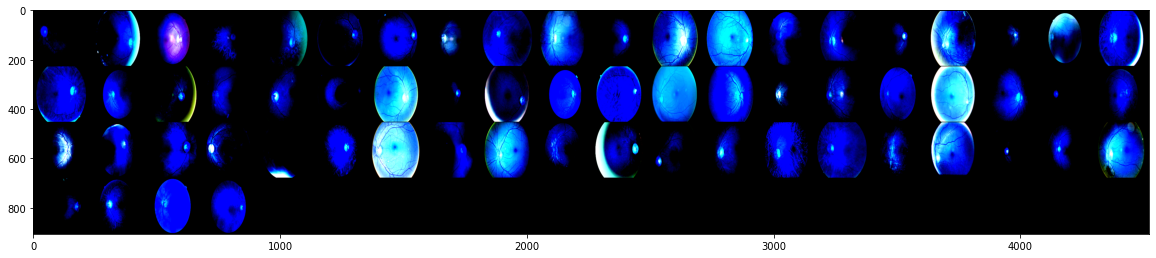

In [27]:
# plotting the images of loaded batch with given fig size and frame data    
grid = torchvision.utils.make_grid(images, nrow = 20, padding = 2)
plt.figure(figsize = (20, 20))  
plt.imshow(np.transpose(grid, (1, 2, 0)))   
print('labels:', labels)    

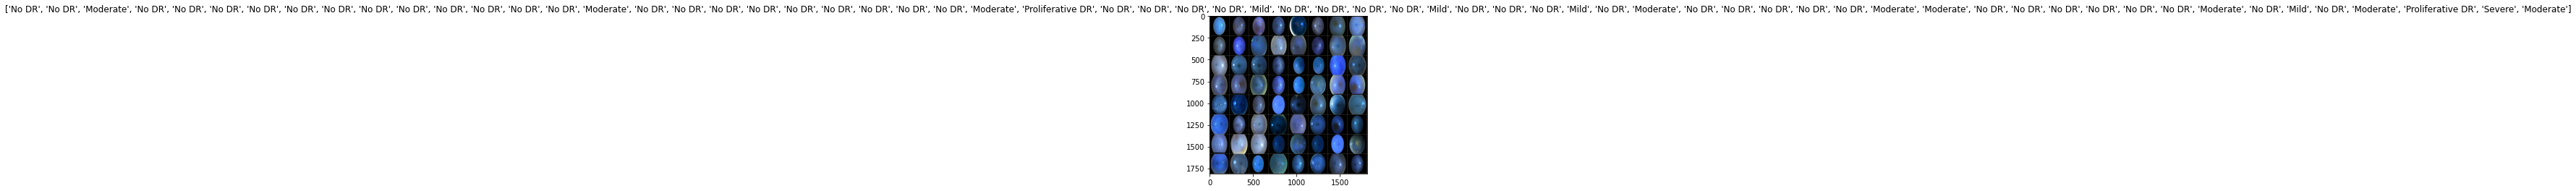

In [28]:
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

images, labels = next(iter(trainloader))
out = torchvision.utils.make_grid(images)
imshow(out, title=[class_names[x] for x in labels])

In [29]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet101(pretrained=True) 

num_ftrs = model.fc.in_features 
out_ftrs = 5 
  
model.fc = nn.Sequential(nn.Linear(num_ftrs, 512),nn.ReLU(),nn.Linear(512,out_ftrs),nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.0001) 

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model.to(device);

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [48]:
model_save_name = 'DR_classifier_Noman_ResNet101.pt'
torch.save(model.state_dict(), f"/content/drive/MyDrive/DR_Noman_1000/{model_save_name}")

In [49]:
# to unfreeze more layers 
for name,child in model.named_children():
  if name in ['layer2','layer3','layer4','fc']:
    print(name + 'is unfrozen')
    for param in child.parameters():
      param.requires_grad = True
  else:
    print(name + 'is frozen')
    for param in child.parameters():
      param.requires_grad = False

conv1is frozen
bn1is frozen
reluis frozen
maxpoolis frozen
layer1is frozen
layer2is unfrozen
layer3is unfrozen
layer4is unfrozen
avgpoolis frozen
fcis unfrozen


In [50]:
#optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.00001) 
#scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [51]:
path = "/content/drive/MyDrive/DR_Noman_1000/DR_classifier_Noman_ResNet101.pt"
def load_model(path):
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  return model

In [52]:
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [53]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [54]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
43326469


In [55]:
# class EarlyStopping():
#     def __init__(self, tolerance=5, min_delta=0):

#         self.tolerance = tolerance
#         self.min_delta = min_delta
#         self.counter = 0
#         self.early_stop = False

#     def __call__(self, train_loss, validation_loss):
#         if (validation_loss - train_loss) > self.min_delta:
#             self.counter +=1
#             if self.counter >= self.tolerance:  
#                 self.early_stop = True

In [56]:
#early_stopping = EarlyStopping(tolerance=5, min_delta=10)

def train_and_test(e):
    epochs = e
    train_losses , test_losses, acc = [] , [], []
    #val_acc = [] , [], []
    valid_loss_min = np.Inf 
    model.train()
    print("Model Training started.....")
    for epoch in range(epochs):
      running_loss = 0
      batch = 0
      for images , labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        batch += 1
        if batch % 10 == 0:
            print(f" epoch {epoch + 1} batch {batch} completed") 
      test_loss = 0
      accuracy = 0
      #val_accuracy = 0
      with torch.no_grad():
        print(f"validation started for {epoch + 1}")
        model.eval() 
        for images , labels in validloader:
          images, labels = images.to(device), labels.to(device)
          logps = model(images) 
          test_loss += criterion(logps,labels) 
          ps = torch.exp(logps)
          top_p , top_class = ps.topk(1,dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor))

      train_losses.append(running_loss/len(trainloader))
      test_losses.append(test_loss/len(validloader))
      acc.append(accuracy)
      #val_acc.append(val_accuracy)
      scheduler.step()
      print("Epoch: {}/{}.. ".format(epoch+1, epochs),"Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),"Valid Loss: {:.3f}.. ".format(test_loss/len(validloader)),
        "Valid Accuracy: {:.3f}".format(accuracy/len(validloader)))
      model.train() 
      if test_loss/len(validloader) <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,test_loss/len(validloader))) 
        torch.save({
            'epoch': epoch,
            'model': model,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': valid_loss_min
            }, path)
        valid_loss_min = test_loss/len(validloader)

        # early_stopping(train_losses, test_losses)
        # if early_stopping.early_stop:
        #     print("We are at epoch:", i)
        #     break    
    print('Training Completed Succesfully !')    
    return train_losses, test_losses, acc 

In [57]:
import time
t0 = time.time()

In [59]:
train_losses, valid_losses, acc = train_and_test(10)
print("Training time:", time.time()-t0)

Model Training started.....
 epoch 1 batch 10 completed
validation started for 1
Epoch: 1/10..  Training Loss: 0.304..  Valid Loss: 0.925..  Valid Accuracy: 0.777
Validation loss decreased (inf --> 0.925391).  Saving model ...
 epoch 2 batch 10 completed
validation started for 2
Epoch: 2/10..  Training Loss: 0.184..  Valid Loss: 0.986..  Valid Accuracy: 0.699
 epoch 3 batch 10 completed
validation started for 3
Epoch: 3/10..  Training Loss: 0.158..  Valid Loss: 0.832..  Valid Accuracy: 0.715
Validation loss decreased (0.925391 --> 0.831766).  Saving model ...
 epoch 4 batch 10 completed
validation started for 4
Epoch: 4/10..  Training Loss: 0.139..  Valid Loss: 0.875..  Valid Accuracy: 0.742
 epoch 5 batch 10 completed
validation started for 5
Epoch: 5/10..  Training Loss: 0.124..  Valid Loss: 1.145..  Valid Accuracy: 0.699
 epoch 6 batch 10 completed
validation started for 6
Epoch: 6/10..  Training Loss: 0.107..  Valid Loss: 0.770..  Valid Accuracy: 0.773
Validation loss decreased (0.

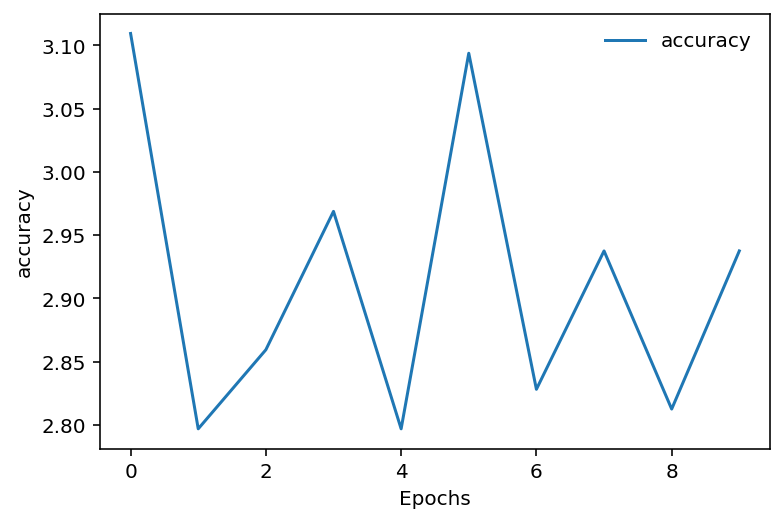

In [60]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(acc, label='accuracy')
plt.legend("")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend(frameon=False)